# LangChain의 Prebuilt ReAct Agent로 AI 계산기 에이전트 만들기

이 튜토리얼에서는 LangChain의 `create_agent` 추상화를 활용하여 ReAct 프레임워크 기반의 AI 에이전트를 구축하는 방법을 다룹니다. 특히, 계산기 툴을 예시로 하여 에이전트의 구성 요소, 동작 방식, 상태 관리 및 커스텀 스테이트 확장 방법을 단계별로 설명합니다. 

LangChain과 LangGraph의 핵심 기능을 이해하고, 실제로 에이전트를 생성·실행하며, 툴과 상태를 효과적으로 활용하는 방법을 학습할 수 있습니다.

**🏆 주로 다루는 내용**
1. ReAct Agent란 무엇인가  
   - LangChain의 `create_agent`를 활용한 ReAct 에이전트의 개념 및 동작 원리 소개
2. Prebuilt Agent의 주요 기능  
   - 메모리 통합, Human-in-the-loop 제어, 스트리밍 지원, 배포 도구 등 `create_agent`의 핵심 기능 설명
3. 계산기 툴을 활용한 에이전트 구축  
   - 기본 계산기 툴을 정의하고, 이를 이용해 에이전트를 생성하는 실습
4. 에이전트의 그래프, 상태, 메시지 구조  
   - 에이전트의 내부 그래프 구조, 상태(State) 및 메시지(Message) 흐름 분석
5. 에이전트 실행 및 결과 해석  
   - 에이전트 실행 과정의 시퀀스 다이어그램 및 LangSmith 트레이스 분석
6. 커스텀 State를 통한 상태 확장  
   - 계산기 툴에 연산 기록 기능을 추가하고, 커스텀 State와 Reducer 함수 구현 방법 설명
7. InjectedState를 활용한 상태 주입  
   - LLM이 직접 접근할 수 없는 State를 툴 실행 시 주입하는 방법 및 구조적 설명
8. Command 객체를 통한 상태 업데이트  
   - 툴 실행 결과를 Command 객체로 반환하여 State의 여러 필드를 동적으로 업데이트하는 방법
9. 병렬 툴 실행 및 복수 연산 처리  
   - 에이전트가 여러 툴 호출을 병렬로 처리하는 예시 실습

**✅ 주요 키워드**
- ReAct Agent
- LangChain
- create_agent
- LangGraph
- ToolNode
- AgentState
- InjectedState
- Command
- ToolMessage
- LLM (Large Language Model)
- State Management

**⭐️ 사전 지식**
- Python 기본 문법 및 함수 정의 방법
- Jupyter Notebook 사용법
- LangChain 및 LangGraph의 기본 개념
- LLM(대형 언어 모델)의 기본 동작 원리
- 타입 힌트(Type Hint)와 Python의 데이터 구조(리스트, 딕셔너리 등) 이해

## 환경 설정

환경 변수는 프로젝트 실행에 필요한 중요한 설정 정보를 담고 있습니다. 

`dotenv` 패키지를 사용하면 환경 변수 파일(`.env`)을 손쉽게 관리할 수 있습니다. 

`dotenv`는 기본적으로 상위 디렉토리(`../.env`)에서 `.env` 파일을 찾으며, 해당 파일이 존재할 경우 그 안의 환경 변수를 현재 셸의 변수보다 우선하여 불러옵니다. 만약 `.env` 파일이 없다면, 현재 셸에 설정된 환경 변수가 그대로 사용됩니다.

이렇게 환경 변수를 미리 설정해두면, 이후 LangChain 및 LangGraph를 활용한 에이전트 개발 과정에서 API 키 등 민감한 정보를 안전하게 관리할 수 있습니다.

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("LangChain-V1-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangChain-V1-Tutorial


## Prebuilt Agent 소개

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

이번 과정에서는 [Deep Agent](https://blog.langchain.com/deep-agents/)를 직접 구현해 봅니다. 

LangChain에서 제공하는 `pre-built` agent 추상화를 활용하면 복잡한 코드를 간결하게 작성할 수 있습니다. 

본 튜토리얼에서는 **Prebuilt ReAct Agent**의 주요 개념과 기능을 다룹니다.

**주요 학습 내용**
- **ReAct Agent란 무엇인가**  
  ReAct Agent의 개념과 동작 원리를 이해할 수 있습니다.
- **Prebuilt Agent의 기능**  
  - 다양한 툴을 활용한 에이전트 구축 방법
  - 내부 그래프, 상태(state), 메시지(message) 구조 분석
  - 툴을 통해 상태에 접근하고 수정하는 방법
  - 🪝 **Hook** 및 구조화된 응답 처리 방식

이 단원을 통해 Prebuilt ReAct Agent의 구조와 동작 방식을 익히고, 실제로 툴과 상태를 활용하는 방법을 단계별로 학습할 수 있습니다. 

추가적인 내용은 [Deep Agent 공식 블로그](https://blog.langchain.com/deep-agents/)에서 확인할 수 있습니다.

### ReAct Agent란 무엇인가

![](./assets/agent.png)

**ReAct Agent**는 LangChain의 오픈소스 `create_agent`([공식 문서](https://docs.langchain.com/oss/python/langchain/agents)) 추상화를 활용하여 구현할 수 있습니다. 

ReAct Agent는 "Reasoning and Acting" 프레임워크를 기반으로, 체인 오브 쏘트(Chain-of-Thought, CoT) 추론과 외부 툴 사용을 결합한 AI 에이전트입니다. 

이 개념은 [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629) 논문을 통해 널리 알려졌습니다.

ReAct Agent는 크게 세 가지 구성 요소로 이루어집니다.  
- **LLM(Large Language Model)**  
- 사용할 수 있는 다양한 **툴(tool) 집합**  
- 에이전트의 동작 방식을 안내하는 **프롬프트(prompt)**

에이전트의 동작 방식은 반복적인 루프 구조로 이루어집니다. LLM은 매 반복마다 현재 컨텍스트와 사용 가능한 툴 목록을 확인한 뒤, 툴 호출이 필요한지 판단합니다. 필요하다면 적절한 툴을 선택하여 호출 요청을 생성하고, 이 요청은 `tool node`로 전달되어 실제 툴이 실행됩니다. 툴 실행 결과(Observation)는 다시 LLM에 전달되며, LLM은 이 결과를 바탕으로 다음 행동을 결정합니다. 이러한 과정은 에이전트가 더 이상 툴 호출이 필요하지 않다고 판단할 때까지 반복됩니다.

이처럼 ReAct Agent는 LLM의 추론 능력과 외부 툴의 실행 결과를 유기적으로 결합하여, 복잡한 문제 해결 과정을 단계적으로 수행할 수 있습니다.

#### `create_agent`의 주요 기능

`create_agent` 추상화는 다양한 고급 기능을 기본적으로 제공합니다. 본 튜토리얼에서는 모든 기능을 다루지는 않지만, 이러한 기능들이 `create_agent`를 활용하는 이유를 잘 보여줍니다.

- **메모리 통합**  
  `create_agent`는 _단기 메모리_ (세션 기반)와 _장기 메모리_ (세션 간 유지)를 모두 지원하여, 챗봇이나 어시스턴트가 상태를 기억하고 활용할 수 있도록 합니다. 자세한 내용은 [메모리 통합 가이드](../how-tos/memory/add-memory.md)를 참고하시기 바랍니다.

- **Human-in-the-loop 제어**  
  에이전트 실행 중 언제든지 _무기한_으로 일시 정지하여 사용자의 피드백을 받을 수 있습니다. 이는 실시간 상호작용에 제한이 있는 websocket 기반 솔루션과 달리, 워크플로우의 어느 단계에서든 비동기적으로 승인, 수정, 개입이 가능합니다. 관련 개념은 [Human-in-the-loop 문서](../concepts/human_in_the_loop.md)에서 확인할 수 있습니다.

- **스트리밍 지원**  
  에이전트의 상태, 모델 토큰, 툴 출력, 또는 이들의 통합 스트림을 실시간으로 스트리밍할 수 있습니다. 자세한 방법은 [스트리밍 가이드](../how-tos/streaming.md)를 참고하시기 바랍니다.

- **배포 도구 제공**  
  별도의 인프라 없이도 에이전트를 손쉽게 배포할 수 있는 다양한 도구를 지원합니다.  
  - [**LangGraph Platform**](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)을 통해 테스트, 디버깅, 배포가 가능합니다.
  - [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/)는 워크플로우를 시각적으로 점검하고 디버깅할 수 있는 IDE를 제공합니다.
  - [LangSmith](https://smith.langchain.com/)는 트레이싱 및 평가 도구로 활용할 수 있습니다.
  - 실제 운영 환경에 맞는 다양한 [배포 옵션](https://langchain-ai.github.io/langgraph/concepts/deployment_options.md)도 지원합니다.

이처럼 `create_agent`는 메모리, 사용자 개입, 실시간 스트리밍, 배포 등 실전 환경에서 필요한 핵심 기능을 폭넓게 제공하여, 복잡한 에이전트 개발을 효율적으로 지원합니다.

> **참고**  
`create_react_agent` 함수는 LangGraph 라이브러리에서 LangChain 라이브러리로 이동되었으며, 1.0 버전 코드 릴리스 이후 `create_agent`로 이름이 변경되었습니다. 본 강의의 영상과 노트북은 이러한 변경 사항을 반영하여 업데이트되었습니다. 다만, 이후의 일부 강의에서는 노트북만 최신 코드로 반영되어 있으니 참고하시기 바랍니다.

#### 툴을 활용한 에이전트 구축

이제 간단한 calculator 툴을 이용하여 에이전트를 직접 만들어 보겠습니다. 실제로 에이전트와 툴이 어떻게 결합되어 동작하는지 확인한 후, 각 구성 요소와 동작 원리에 대해 자세히 살펴보겠습니다.

In [2]:
from typing import Annotated, List, Literal, Union

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


# calculator 툴 함수 정의 및 타입 힌트 적용
@tool
def calculator(
    operation: Literal["add", "subtract", "multiply", "divide"],
    a: Union[int, float],
    b: Union[int, float],
) -> Union[int, float]:
    # 두 개의 입력값과 연산 종류를 받아 정확한 결과를 반환하는 계산기 툴
    """
    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.

    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    # 0으로 나누는 경우 에러 메시지 반환
    if operation == "divide" and b == 0:
        return {"error": "Division by zero is not allowed."}

    # 연산 종류에 따라 덧셈, 뺄셈, 곱셈, 나눗셈 수행
    if operation == "add":
        result = a + b
    elif operation == "subtract":
        result = a - b
    elif operation == "multiply":
        result = a * b
    elif operation == "divide":
        result = a / b
    else:
        # 지원하지 않는 연산 종류 입력 시 에러 문자열 반환
        result = "unknown operation"
    # 계산 결과 반환
    return result

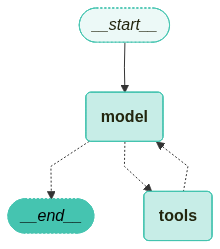

In [3]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain.agents import create_agent
from utils import format_messages
from langchain_teddynote.graphs import visualize_graph

# 시스템 프롬프트 정의
SYSTEM_PROMPT = """You are a helpful arithmetic assistant who is an expert at using a calculator.
Return all text as plain text without Markdown math delimiters.
"""

# LLM 인스턴스 생성
model = init_chat_model(model="openai:gpt-4.1-mini", temperature=0.0)

# 도구 목록에 Tool 추가
tools = [calculator]

# ReAct Agent 생성
agent = create_agent(
    model,
    tools,
    system_prompt=SYSTEM_PROMPT,
).with_config(
    {"recursion_limit": 20}
)  # 에이전트 반복 실행 최대 횟수 제한

# 그래프 시각화
visualize_graph(agent)

In [4]:
# 생성된 Agent 의 타입 확인
type(agent)

langgraph.graph.state.CompiledStateGraph

### 에이전트의 그래프, 상태, 메시지 구조

앞서 에이전트를 정의하고 그래프를 시각화하였습니다. 이제 실제로 에이전트를 실행하기 전에, 내부 구조와 동작 원리를 조금 더 깊이 살펴보겠습니다.

에이전트는 모델, 하나 이상의 툴, 시스템 프롬프트, 그리고 기본적으로 `AgentState`(메시지 리스트 기반)를 포함하는 상태 스키마를 입력받아 정의됩니다.  

`AgentState`에 대한 자세한 구현은 [GitHub 소스코드](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py#L62-L69)에서 확인할 수 있습니다.  

에이전트 생성 시 내부적으로 LangGraph의 그래프가 자동으로 정의되고 컴파일됩니다. 이 그래프의 핵심은 LLM이 생성한 메시지에서 툴 호출을 식별하고, 이를 처리하는 `ToolNode`입니다.  

`ToolNode`는 LLM이 요청한 모든 툴을 실행한 뒤, 그 결과를 반환하는 역할을 합니다.  
`ToolNode`의 상세 동작은 [공식 소스코드](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/tool_node.py#L239-L293)에서 확인할 수 있습니다.

에이전트의 실제 호출 방식과 세부 동작 원리는 [공식 문서](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent)에서 자세히 안내되어 있습니다.

직접 간단한 버전을 구현해보고 싶다면 [Foundation: Introduction to LangGraph, Module 1, Lesson 6, Agent](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent) 강의를 참고할 수 있습니다.

이제 에이전트를 직접 호출하여 결과를 확인해 보겠습니다.

In [ ]:
from langchain_teddynote.messages import invoke_graph

inputs = {"messages": [{"role": "user", "content": "What is 3.1 * 4.2?"}]}

invoke_graph(agent, inputs)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  calculator (call_FTU3bqIKHRPlpedlu6EXLeZE)
 Call ID: call_FTU3bqIKHRPlpedlu6EXLeZE
  Args:
    operation: multiply
    a: 3.1
    b: 4.2

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: calculator

13.020000000000001

🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

3.1 multiplied by 4.2 is 13.02.


### 에이전트 실행 시퀀스 이해하기

아래 시퀀스 다이어그램은 에이전트가 실제로 호출될 때 내부적으로 어떤 과정이 진행되는지 한눈에 보여줍니다.

![에이전트 시퀀스 다이어그램](./assets/agent_sequence_diagram.png)

사용자가 `"What is 3.1 * 4.2?"`와 같은 입력을 전달하면, 이 입력은 시스템 프롬프트 및 툴 설명과 함께 LLM에 전달됩니다.

LLM은 현재 입력과 컨텍스트를 바탕으로, `calculator` 툴을 호출해야 한다고 판단합니다. 이때, LLM은 아래와 같이 `AIMessage`를 `messages`에 추가합니다.

```python
AIMessage(
    content="",
    tool_calls=[{
        "id": "call_123",
        "name": "calculator",
        "args": {"a": 3.1, "b": 4.2, "operation": "multiply"}
    }]
)
```

`ToolNode`는 이 `AIMessage`를 받아 모든 툴 호출을 처리하며, 각 호출에 대한 `tool_call_id`를 추적합니다. 툴 실행이 완료되면, 결과를 다음과 같이 `ToolMessage` 형태로 반환합니다.

```python
ToolMessage(
    content="13.02",         # 툴 실행 결과
    tool_call_id="call_123"  # AIMessage.tool_calls의 id와 일치
)
```

LLM은 `messages` 내의 툴 실행 결과를 확인한 후, 추가적인 툴 호출이 필요하지 않다고 판단하면 최종적으로 사용자에게 응답을 반환합니다.

이와 같은 구조를 통해, 에이전트는 LLM의 추론과 외부 툴의 실행을 반복적으로 결합하여 복잡한 문제를 단계적으로 해결할 수 있습니다.  
실제 동작 방식과 내부 메시지 흐름을 시각적으로 이해하면, 이후 커스텀 상태 확장이나 복수 툴 실행 등 고급 기능 구현 시에도 큰 도움이 됩니다.

LangSmith에서의 [이전 트레이스 예시](https://smith.langchain.com/public/3d2062e3-8713-4510-a797-801abe44d1f7/r)를 참고하면, 에이전트 실행 과정에서 주목할 만한 몇 가지 포인트가 있습니다.

- LLM 호출의 메타데이터에는 `calculator` 툴의 설명이 포함되어 있습니다.
- 모델의 응답은 툴 호출 형태로 반환되며, 인자값이 명확하게 전달됩니다.
- 마지막 LLM 호출에서는 `tool node`가 제공하는 `tool_call_id`가 일치하는 것을 확인할 수 있습니다.

이처럼 LangSmith 트레이스를 활용하면, 에이전트 내부에서 툴 설명이 어떻게 전달되고, 툴 호출 및 결과가 어떤 구조로 오가는지 구체적으로 파악할 수 있습니다. 실제 트레이스 예시는 [LangSmith 공개 트레이스 링크](https://smith.langchain.com/public/3d2062e3-8713-4510-a797-801abe44d1f7/r)에서 직접 확인할 수 있습니다.  
이러한 분석을 통해 에이전트의 동작 흐름과 메시지 구조를 더욱 명확하게 이해할 수 있습니다.

#### 직접 실습해보기

이제 직접 에이전트를 실행해 볼 차례입니다. 원하는 계산 질의를 입력하여 결과를 확인하고, LangSmith에서 트레이스를 분석해 보시기 바랍니다. 실제 실행 결과가 예상과 일치하는지 점검해 보세요.

추가로, `calculator` 툴을 확장하여 새로운 기능을 구현해 볼 수 있습니다. 예를 들어, 제곱 연산(square)을 지원하는 함수를 추가해 보며, 툴의 활용 범위를 넓혀보시기 바랍니다.

이러한 실습을 통해 에이전트의 동작 원리와 툴 확장 방법을 더욱 깊이 이해할 수 있습니다. LangSmith 트레이스 분석 방법은 [LangSmith 공식 사이트](https://smith.langchain.com/)에서 자세히 확인할 수 있습니다.

In [ ]:
# 사용자 질의 메시지 리스트를 에이전트에게 전달하여 계산 요청 수행
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is ...?",
            }
        ],
    }
)

# 에이전트의 응답 메시지 리스트를 보기 좋게 포맷팅하여 출력
format_messages(result["messages"])

### 툴 내에서 State 접근 및 수정하기

LangGraph의 핵심 기능 중 하나는 **State(상태) 관리**입니다. 그래프 실행 중 각 노드에서는 타입이 지정된 데이터 구조인 `state`에 접근할 수 있으며, 이 상태는 장기 저장소에 영구적으로 보관할 수도 있습니다. 이를 통해 노드 간 정보를 공유하거나, 그래프의 동작을 디버깅하거나, 장시간 실행되는 그래프를 특정 시점으로 되돌리는 등의 다양한 활용이 가능합니다.

그래프의 상태를 정의할 때는 데이터 타입과 함께 `reducer` 함수를 지정합니다. `reducer`는 해당 상태 요소에 정보가 어떻게 추가되는지 규정하는 함수입니다. 특히, 하나의 작업이 여러 노드에 매핑되어 병렬로 실행되면서 동시에 상태를 업데이트해야 할 때 매우 유용하게 사용됩니다.

이번 예제에서는 기본적으로 제공되는 `AgentState`를 사용하였습니다. `AgentState`의 정의는 [langgraph.prebuilt.chat_agent_executor](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py)에서 확인할 수 있습니다.

```python
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    remaining_steps: NotRequired[RemainingSteps]
```

- `messages`는 LLM과 주고받는 모든 메시지를 담는 리스트로, [langchain_core](https://github.com/langchain-ai/langchain/blob/088095b663993b1e53cf616e1ca487d1739b0d71/libs/core/langchain_core/messages/base.py)에 정의된 `BaseMessage` 타입을 사용합니다.
    - `typing.Annotated`를 활용하면 타입 힌트에 메타데이터를 추가할 수 있습니다. 예시: `Annotated[Type, metadata1, metadata2, ...]`
- `add_messages` reducer는 새로운 메시지를 메시지 리스트의 끝에 순차적으로 추가합니다.
- `remaining_steps`는 그래프 내에서 남은 실행 단계를 추적하는 필드입니다. 에이전트 생성 시 `recursion_limit` 값으로 초기화되지만, 실제로는 그래프 내부에서 관리되며 사용자에게는 노출되지 않습니다.

이처럼 LangGraph의 상태 관리 구조를 이해하면, 노드 간 정보 공유 및 복잡한 워크플로우 구현이 훨씬 수월해집니다.  
다음 단계에서는 실제로 상태가 어떻게 동작하는지 간단히 살펴보겠습니다.

In [8]:
# 에이전트 실행 결과 메시지 리스트를 JSON 형태로 시각적으로 출력
from IPython.display import JSON
from langchain_core.messages import messages_to_dict

# 메시지 객체 리스트를 딕셔너리로 변환 후 JSON 포맷으로 출력하여 구조 확인
JSON({"messages": messages_to_dict(result1["messages"])})

<IPython.core.display.JSON object>

#### 커스텀 State 확장

이제 계산기 에이전트에 **연산 기록 기능**을 추가해 보겠습니다. 이를 위해 상태(state)에 연산 내역을 저장할 리스트를 새롭게 정의하고, 각 연산 결과가 리스트에 안전하게 추가될 수 있도록 `reducer` 함수를 구현해야 합니다. 이 방식은 연산 내역이 비어 있거나 리스트가 없는 경우에도 오류 없이 동작하도록 설계할 수 있습니다.

이처럼 커스텀 State와 reducer를 활용하면, 에이전트가 수행한 모든 연산을 체계적으로 기록하고 관리할 수 있습니다.  
이후 단계에서는 실제로 커스텀 State를 정의하고, 연산 기록이 정상적으로 누적되는지 확인하는 방법을 살펴보겠습니다.

In [ ]:
from langchain.agents import AgentState  # updated in 1.0

# AgentState 클래스 임포트 경로 변경 및 1.0 버전 호환성 확보


# 두 리스트를 안전하게 병합하는 함수, None 입력 시 빈 리스트로 처리
def reduce_list(left: list | None, right: list | None) -> list:
    """두 리스트를 안전하게 병합, 입력값이 None일 경우 빈 리스트로 처리

    Args:
        left (list | None): 병합할 첫 번째 리스트 또는 None
        right (list | None): 병합할 두 번째 리스트 또는 None

    Returns:
        list: 두 입력 리스트의 모든 요소를 포함하는 새 리스트, None은 빈 리스트로 간주
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right


# 에이전트 상태를 확장하여 연산 기록 리스트(ops) 필드 추가 및 커스텀 reducer 지정
class CalcState(AgentState):
    """그래프 상태 클래스"""

    ops: Annotated[List[str], reduce_list]

#### State 접근과 주입

이제 계산기 툴에 상태(state) 업데이트 기능을 추가할 수 있습니다. 하지만 여기서 중요한 점이 있습니다. 상태가 calculator 툴의 인자로 추가되면, LLM이 툴 호출을 생성할 때 `state` 인자를 직접 구성할 수 없다는 문제가 발생합니다.

<img src="./assets/state_arg_diagram.png" width="800" style="display:block; margin-left:0;">

위 다이어그램에서 볼 수 있듯이, LLM은 툴 호출을 생성하는 역할을 담당하지만, 현재 컨텍스트에 `state` 정보가 포함되어 있지 않으므로 해당 인자를 직접 전달할 수 없습니다.

이 문제를 해결하기 위해서는 LLM이 툴 호출을 생성한 이후, **state를 툴 실행 시점에 주입(inject)** 하는 방식이 필요합니다.

<img src="./assets/inject_state_diagram.png" width="1000" style="display:block; margin-left:0;">

이처럼 LangGraph에서는 LLM이 직접 접근할 수 없는 정보를 툴 실행 단계에서 안전하게 주입할 수 있습니다. 이를 통해 에이전트의 상태를 효과적으로 관리하고, 툴 실행 시 필요한 정보를 유연하게 전달할 수 있습니다.  
이 구조를 이해하면, 이후 커스텀 상태 확장이나 복잡한 워크플로우 구현 시에도 안정적으로 상태를 활용할 수 있습니다.

아래와 같이 `InjectedState` 어노테이션을 활용하면, 툴 함수의 인자 중 `state`와 `tool_call_id`를 LLM에게 노출하지 않고 툴 실행 시점에 안전하게 주입할 수 있습니다.

```python
@tool
def calculator_wstate(
    operation: Literal["add","subtract","multiply","divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],         # ← LLM에 전달되지 않음
    tool_call_id: Annotated[str, InjectedToolCallId],   # ← LLM에 전달되지 않음
) -> Union[int, float]:
```

이 방식은 툴 설명에서 `state`와 같은 내부 정보를 자동으로 제거하여 LLM이 해당 인자를 인식하지 못하도록 처리합니다. 실제 툴 실행 단계에서는 `ToolNode`가 내부적으로 `state`와 `tool_call_id`를 주입하여, 툴 함수가 필요한 정보를 안전하게 사용할 수 있도록 합니다.  
`tool_call_id`의 역할과 동작 방식은 다음 절에서 자세히 설명합니다.

#### State 업데이트 방법

앞서 툴 실행 결과는 일반적으로 `ToolMessage` 형태로 반환되어, 에이전트의 상태 중 `messages` 필드에 추가된다는 점을 설명하였습니다. 만약 상태의 다른 필드도 함께 업데이트하고 싶다면, 반환값을 확장하여 여러 필드를 동시에 갱신할 수 있습니다. 이를 위해 `Command` 객체를 활용합니다.

아래 예시와 같이, 툴 함수에서 `Command`를 반환하면 `ops`와 `messages` 등 여러 상태 필드를 한 번에 업데이트할 수 있습니다.

```python
return Command(
    update={
        "ops": ops,
        "messages": [
            ToolMessage(f"{result}", tool_call_id=tool_call_id)
        ]
    }
)
```

이때 `ToolMessage`를 생성하기 위해서는 반드시 `tool_call_id`가 필요합니다.  
이와 같은 방식으로, 툴 실행 결과를 다양한 상태 필드에 구조적으로 반영할 수 있으며, 복잡한 상태 관리가 필요한 에이전트 개발에 매우 유용하게 활용됩니다.

In [ ]:
# calculator_wstate 툴 함수 정의, 두 입력값과 연산 종류, 상태, 툴 호출 ID를 인자로 받음
@tool
def calculator_wstate(
    operation: Literal["add", "subtract", "multiply", "divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],  # LLM에 노출되지 않는 상태 주입 인자
    tool_call_id: Annotated[
        str, InjectedToolCallId
    ],  # LLM에 노출되지 않는 툴 호출 ID 주입 인자
) -> Union[int, float]:
    # 두 개의 입력값과 연산 종류를 받아 계산 수행 및 상태 업데이트 Command 반환
    """
    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.

    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    # 0으로 나누는 경우 에러 메시지 반환
    if operation == "divide" and b == 0:
        return {"error": "Division by zero is not allowed."}

    # 연산 종류에 따라 덧셈, 뺄셈, 곱셈, 나눗셈 수행
    if operation == "add":
        result = a + b
    elif operation == "subtract":
        result = a - b
    elif operation == "multiply":
        result = a * b
    elif operation == "divide":
        result = a / b
    else:
        result = "unknown operation"
    # 연산 기록 문자열 리스트 생성, ops 필드에 추가
    ops = [f"({operation}, {a}, {b}),"]
    # Command 객체 반환, ops와 messages 필드 동시 업데이트
    return Command(
        update={
            "ops": ops,
            "messages": [ToolMessage(f"{result}", tool_call_id=tool_call_id)],
        }
    )

In [ ]:
# 계산기 전문 도우미 역할을 명시하는 시스템 프롬프트 정의
SYSTEM_PROMPT = """
You are a helpful arithmetic assistant who is an expert at using a calculator.
Return all text as plain text without Markdown math delimiters.
"""

# GPT-4o-mini 모델 인스턴스 생성 및 온도 0.0으로 설정하여 일관된 응답 유도
model = init_chat_model(model="openai:gpt-4.1-mini", temperature=0.0)
# 연산 기록 기능이 포함된 calculator_wstate 툴을 툴 목록에 추가
tools = [calculator_wstate]  # new tool

# 커스텀 상태 스키마(CalcState)와 시스템 프롬프트를 적용하여 Prebuilt ReAct Agent 생성
agent = create_agent(
    model,
    tools,
    system_prompt=SYSTEM_PROMPT,
    state_schema=CalcState,  # now defining state scheme
).with_config(
    {"recursion_limit": 20}
)  # 에이전트 반복 실행 최대 횟수 제한 설정

In [ ]:
# 에이전트에게 곱셈 질의 메시지 리스트 전달, 계산 요청 수행 및 결과 반환
result2 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2?",
            }
        ],
    }
)

# 에이전트 응답 메시지 리스트를 보기 좋게 포맷팅하여 출력, 메시지 구조 확인
format_messages(result2["messages"])

In [ ]:
# 에이전트 실행 결과 전체 상태(ops 포함)를 JSON 포맷으로 시각적으로 출력
JSON(result2)

이번에는 두 개의 툴 호출이 동시에 이루어지는 예시를 살펴보겠습니다. 이 경우, `tool node`는 각 툴 호출을 병렬로 실행하여 결과를 반환합니다.  
이처럼 복수의 툴 호출이 병렬로 처리되는 구조를 이해하면, 에이전트가 여러 작업을 효율적으로 수행하는 방식에 대해 더욱 깊이 있게 학습할 수 있습니다.

In [ ]:
# 복수 연산 질의 메시지 리스트를 에이전트에게 전달하여 병렬 계산 요청 수행
result3 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2 + 5.5 * 6.5?",
            }
        ],
    }
)

# 에이전트의 응답 메시지 리스트를 보기 좋게 포맷팅하여 출력
format_messages(result3["messages"])

In [ ]:
# 에이전트 실행 결과 전체 상태(result3)를 JSON 포맷으로 시각적으로 출력하여 구조 및 연산 기록 확인
JSON(result3)

In [ ]:
# 사용자에게 에이전트가 직접 예시를 생성하도록 질의 메시지 전달 및 결과 반환
result4 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Create an example of your own?",
            }
        ],
    }
)

# 에이전트의 응답 메시지 리스트를 보기 좋게 포맷팅하여 출력
format_messages(result4["messages"])

In [ ]:
# calculator_wstate 툴 함수 정의, 연산 종류 및 입력값, 상태, 툴 호출 ID를 인자로 받음
@tool
def calculator_wstate(
    operation: Literal["add", "subtract", "multiply", "divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],  # LLM에 노출되지 않는 상태 주입 인자
    tool_call_id: Annotated[
        str, InjectedToolCallId
    ],  # LLM에 노출되지 않는 툴 호출 ID 주입 인자
) -> Union[int, float]:
    """
    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.

    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    # 0으로 나누는 경우 에러 메시지 반환
    if operation == "divide" and b == 0:
        return {"error": "Division by zero is not allowed."}

    # 연산 종류에 따라 덧셈, 뺄셈, 곱셈, 나눗셈 수행
    if operation == "add":
        result = a + b
    elif operation == "subtract":
        result = a - b
    elif operation == "multiply":
        result = a * b
    elif operation == "divide":
        result = a / b
    else:
        result = "unknown operation"
    # 연산 기록 문자열 리스트 생성, ops 필드에 추가
    ops = [f"({operation}, {a}, {b}),"]
    # Command 객체 반환, ops와 messages 필드 동시 업데이트
    return Command(
        update={
            "ops": ops,
            "messages": [ToolMessage(f"{result}", tool_call_id=tool_call_id)],
        }
    )